In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../data/FundDataWithMonthlyReturnsTSNEScoredScaledClustered.csv')

In [5]:
data.head()

,fundRUN,fundName,fundSeries,aafmCategory,svsCategory,svsCategoryId,currency,fundRUNSeries,userCategory,2015-01-31,...,x_coord,y_coord,netPatrimony,providedFlow,rescuedFlow,ann_return,ann_stdev,pca_anomaly,dist_anomaly,cluster
0,8812-9,A. CHILE CALIFICADO,D,Inversionistas Calificados Accionario Nacional,FM DIRIGIDO A INVERSIONISTAS CALIFICADOS,8.0,P,8812-9D,"Domestic Bond, < 365",0.0,...,49.043568,31.558483,2.057013e+08,1.397999e+06,1.624005e+06,0.054833,18.275449,0,0,3
1,8289-9,ACCIONES CHILE,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8289-9APV,Domestic Equity,0.0,...,48.599960,29.826206,9.093564e+07,5.398776e+04,2.750340e+04,-2.699522,18.133874,0,0,3
2,8076-4,ACCIONES CHILENAS,APV,Accionario Nacional Large CAP,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8076-4APV,Domestic Equity,0.0,...,46.495964,24.676537,5.264871e+09,1.849870e+06,3.550476e+06,-0.228134,18.098522,0,0,3
3,9254-1,ACCIONES EUROPA,ALTO,Accionario Europa Desarrollado,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,9254-1ALTO,International Equity,0.0,...,-46.026010,3.815157,1.038922e+09,6.401805e+06,1.216734e+06,0.444373,20.991343,0,0,1
4,8247-3,ACCIONES LATAM,A,Accionario America Latina,FM DE INVERSION EN INSTRUMENTOS DE CAPITALIZACION,5.0,P,8247-3A,International Equity,0.0,...,-2.541078,-44.528522,2.430189e+09,1.271666e+07,8.701922e+06,0.701076,23.831971,0,0,6


In [3]:
cluster_cov = data.groupby('cluster').mean() * 100  # data is in pct
cluster_cov = cluster_cov.loc[:, '2015-02-28':'2021-01-31'].T.cov()
cluster_cov

cluster,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0.780662,0.588936,1.064913,1.929828,3.124154,0.043513,2.001220,0.775171,0.351817,0.943552
1,0.588936,19.300996,4.344940,5.174809,14.466742,0.019838,10.180684,5.202369,13.766962,12.431424
2,1.064913,4.344940,6.020586,6.517531,4.286898,0.033582,14.010491,2.541193,5.108188,5.434112
3,1.929828,5.174809,6.517531,26.820200,17.060786,0.058555,22.160668,4.581684,7.850423,9.682319
4,3.124154,14.466742,4.286898,17.060786,89.825057,0.142471,20.224777,5.889246,9.249828,13.047175
5,0.043513,0.019838,0.033582,0.058555,0.142471,0.007512,0.053297,0.034121,-0.035618,0.025150
6,2.001220,10.180684,14.010491,22.160668,20.224777,0.053297,51.345699,6.184698,12.524889,14.633637
7,0.775171,5.202369,2.541193,4.581684,5.889246,0.034121,6.184698,2.157285,4.360243,4.371465
8,0.351817,13.766962,5.108188,7.850423,9.249828,-0.035618,12.524889,4.360243,16.141834,10.812989


In [4]:
expected_ann_return = data.groupby('cluster')[['ann_return']].mean()
expected_ann_volatility = data.groupby('cluster')[['ann_stdev']].mean()

In [12]:
n = int(1e5)
weights = np.array(np.random.random((n, len(expected_ann_return))))
weights = weights/weights.sum(1).reshape(-1, 1)
returns = np.sum(weights * expected_ann_return.values.ravel(), axis=1)

In [14]:
volatilities = np.zeros(n)
for i in range(n):
    volatilities[i] += np.sqrt(np.dot(weights[i, :].T, np.dot(cluster_cov * 12, weights[i, :])))

In [15]:
sharpes = returns / volatilities

In [9]:
#create 6000 portfolios so we can have a sample of almost all portfolio condition due to volatility and returns.
np.random.seed(42)
num_ports = 10000
all_weights = np.zeros((num_ports, cluster_cov.shape[1]))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(len(expected_ann_return)))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum(weights * expected_ann_return.values.ravel())
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(cluster_cov * 12, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]

In [16]:
#the optimal portfolio is located in this point.
print('Max sharpe ratio in the array: {}'.format(sharpes.max()))
print('Location in the array: {}'.format(sharpes.argmax()))

Max sharpe ratio in the array: 0.7849476444767104
Location in the array: 31167


In [17]:
#the weight of the optimal portfolio is:
print(weights[sharpes.argmax(),:] * 100)

[19.25989897 11.86176002 19.75933932  0.94837924  0.04172498 36.58152206
  0.60007691  3.63655095  0.1507455   7.16000205]


In [18]:
max_sr_ret=returns[sharpes.argmax()]
max_sr_vol=volatilities[sharpes.argmax()]

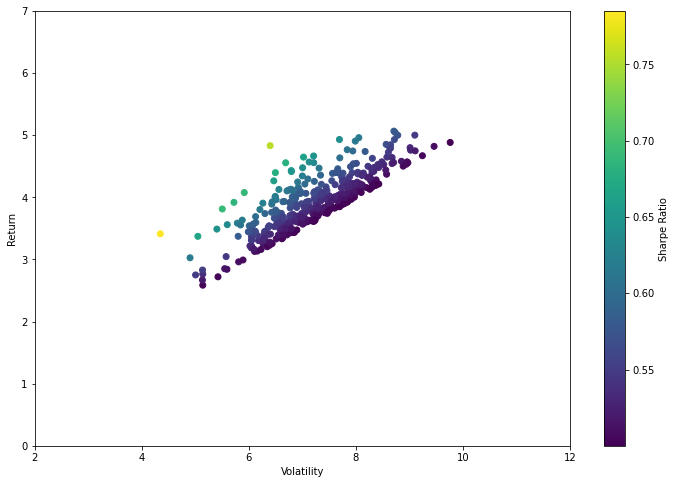

In [19]:
mask = sharpes > .5

plt.figure(figsize=(12,8))
plt.scatter(volatilities[mask], returns[mask], c=sharpes[mask], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
plt.ylim(0, 7)
plt.xlim(2, 12)
plt.show()